In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier

# XGBoost (if needed later)
import xgboost as xgb

# Evaluation
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, precision_recall_curve

# Train-test split (if needed separately later)
from sklearn.model_selection import train_test_split

# Load processed data
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv').squeeze()
y_test = pd.read_csv('../data/y_test.csv').squeeze()

print(f"Training Samples: {X_train.shape[0]}, Testing Samples: {X_test.shape[0]}")


Training Samples: 36168, Testing Samples: 9043


In [2]:
def evaluate_model(model_name, y_true, y_pred, y_proba, save_prefix=None):
    print(f"\n==== {model_name} ====")
    print("Classification Report:\n", classification_report(y_true, y_pred))

    auc = roc_auc_score(y_true, y_proba)
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    pr, rc, _ = precision_recall_curve(y_true, y_proba)

    # ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"{model_name} ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    if save_prefix:
        plt.savefig(f"../results/plots/{save_prefix}_roc.png")
    plt.grid()
    plt.show()

    # PR Curve
    plt.figure()
    plt.plot(rc, pr, label=model_name)
    plt.title(f"{model_name} Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    if save_prefix:
        plt.savefig(f"../results/plots/{save_prefix}_prc.png")
    plt.grid()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    if save_prefix:
        plt.savefig(f"../results/plots/{save_prefix}_confusion_matrix.png")
    plt.show()

    return auc



==== Random Forest ====
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94      7985
           1       0.62      0.19      0.29      1058

    accuracy                           0.89      9043
   macro avg       0.76      0.59      0.61      9043
weighted avg       0.87      0.89      0.86      9043



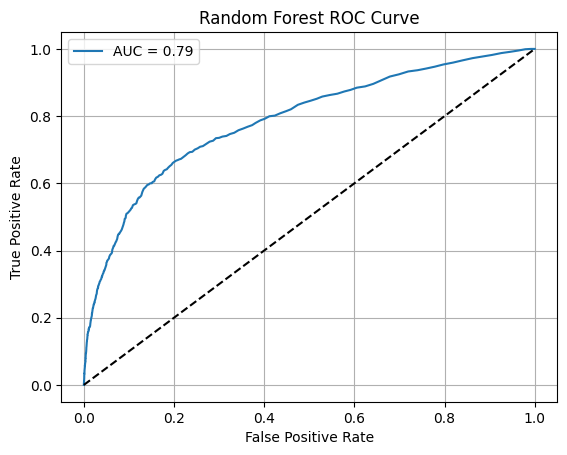

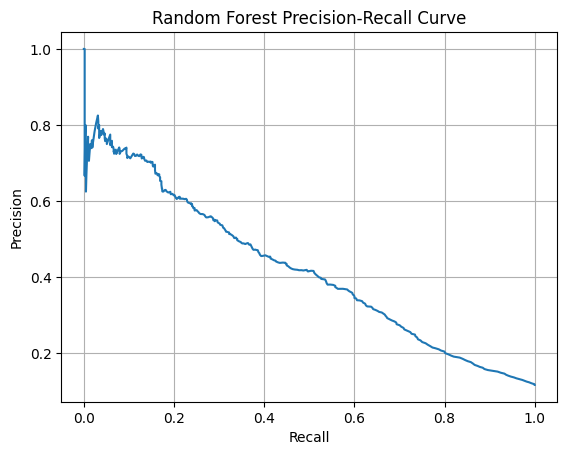

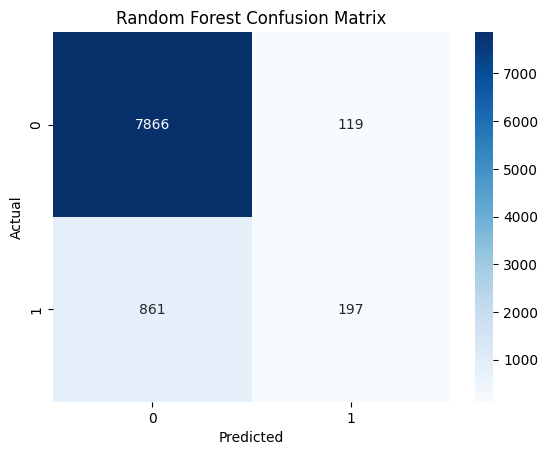

Random Forest AUC: 0.7882


In [3]:
# Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate using the helper
auc_rf = evaluate_model("Random Forest", y_test, y_pred_rf, y_proba_rf, save_prefix="rf")
print(f"Random Forest AUC: {auc_rf:.4f}")


c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:19:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



==== XGBoost ====
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.86      0.90      7985
           1       0.37      0.60      0.46      1058

    accuracy                           0.83      9043
   macro avg       0.65      0.73      0.68      9043
weighted avg       0.87      0.83      0.85      9043



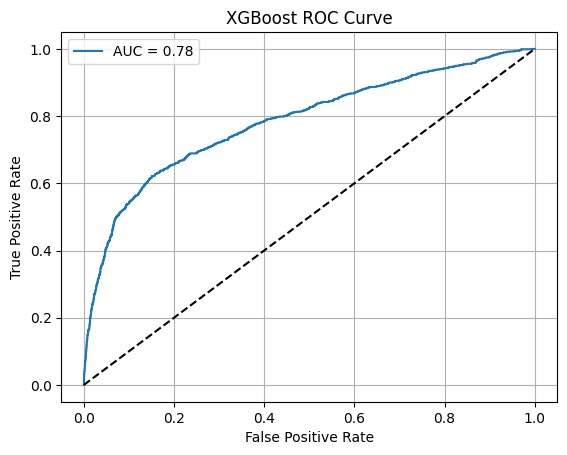

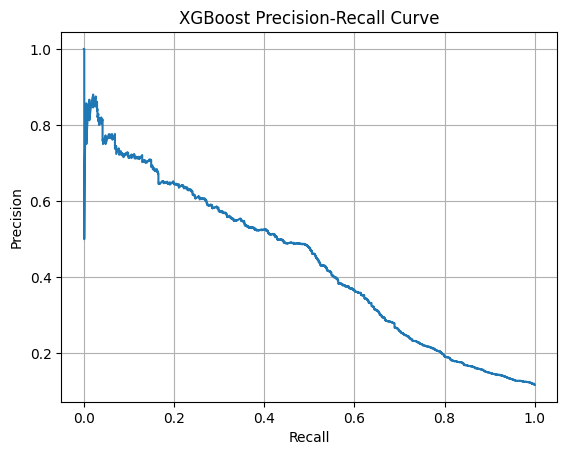

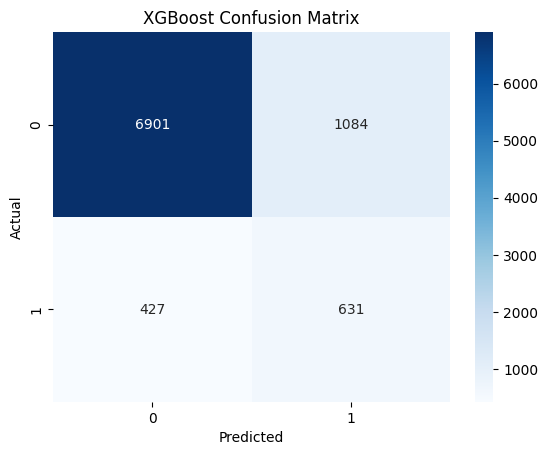

XGBoost AUC: 0.7844


In [4]:
# Gradient Boosting (XGBoost)
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # to balance classes
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate using helper
auc_xgb = evaluate_model("XGBoost", y_test, y_pred_xgb, y_proba_xgb, save_prefix="xgb")
print(f"XGBoost AUC: {auc_xgb:.4f}")


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



==== MLP Neural Network ====
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      7985
           1       0.61      0.23      0.33      1058

    accuracy                           0.89      9043
   macro avg       0.76      0.60      0.64      9043
weighted avg       0.87      0.89      0.87      9043



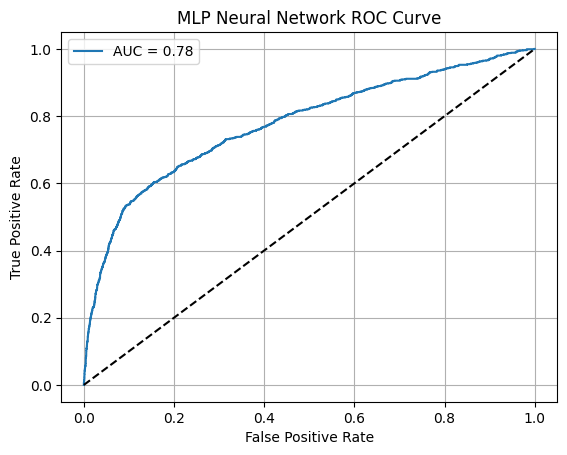

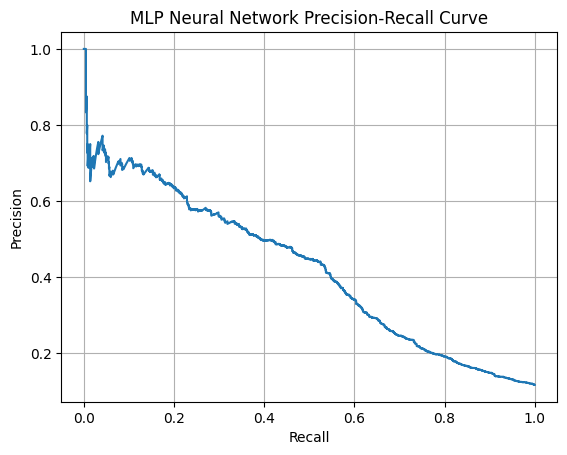

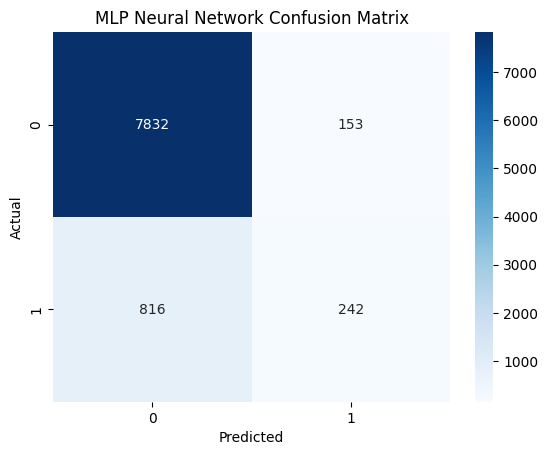

MLP AUC: 0.7765


In [6]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    max_iter=300,
    early_stopping=True,
    random_state=42
)

mlp_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_mlp = mlp_model.predict(X_test_scaled)
y_proba_mlp = mlp_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
auc_mlp = evaluate_model("MLP Neural Network", y_test, y_pred_mlp, y_proba_mlp, save_prefix="mlp")
print(f"MLP AUC: {auc_mlp:.4f}")



==== Stacked Ensemble ====
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      7985
           1       0.65      0.24      0.35      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.61      0.64      9043
weighted avg       0.88      0.90      0.87      9043



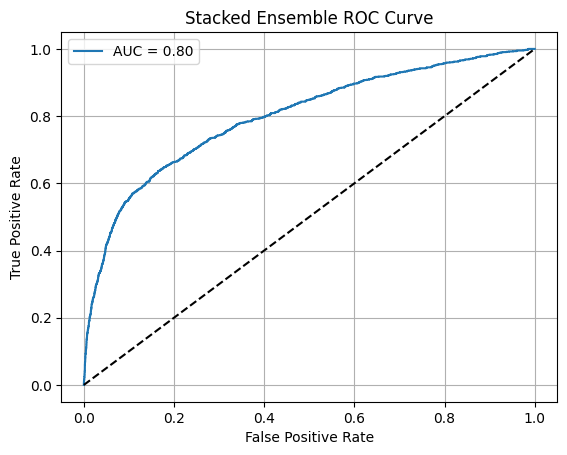

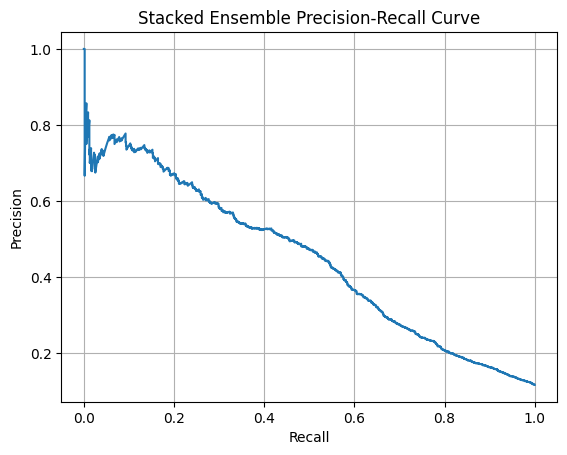

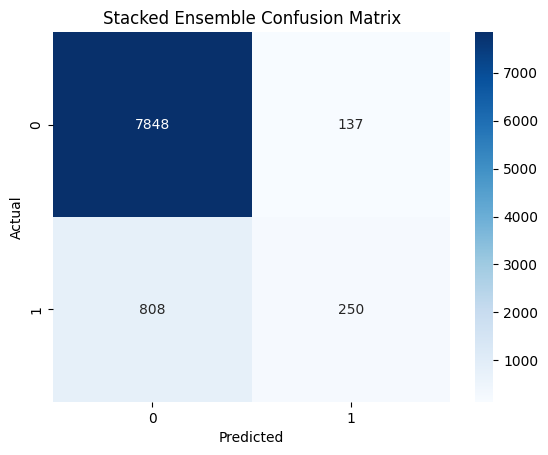

Stacked Ensemble AUC: 0.7989


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

# Recreate models for stacking (can't reuse already-fitted ones)
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42)),
    ('xgb', xgb.XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )),
    ('mlp', MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu',
                          alpha=0.001, max_iter=300, early_stopping=True,
                          random_state=42))
]

# Meta-learner
meta_learner = LogisticRegression(max_iter=200)

# Stacking Classifier
stacked_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    passthrough=True,
    n_jobs=-1
)

# Fit on scaled inputs (since MLP needs scaling)
stacked_model.fit(X_train_scaled, y_train)

# Predict
y_pred_stack = stacked_model.predict(X_test_scaled)
y_proba_stack = stacked_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
auc_stack = evaluate_model("Stacked Ensemble", y_test, y_pred_stack, y_proba_stack, save_prefix="stacked")
print(f"Stacked Ensemble AUC: {auc_stack:.4f}")


Dataset shape: (45211, 16)
Number of classes: 2
Class distribution:
y
0    39922
1     5289
Name: count, dtype: int64

===== Random Forest =====

--- Random Forest Results ---
Accuracy: 0.9064
AUC-ROC: 0.9250

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7985
           1       0.66      0.42      0.51      1058

    accuracy                           0.91      9043
   macro avg       0.79      0.70      0.73      9043
weighted avg       0.90      0.91      0.90      9043



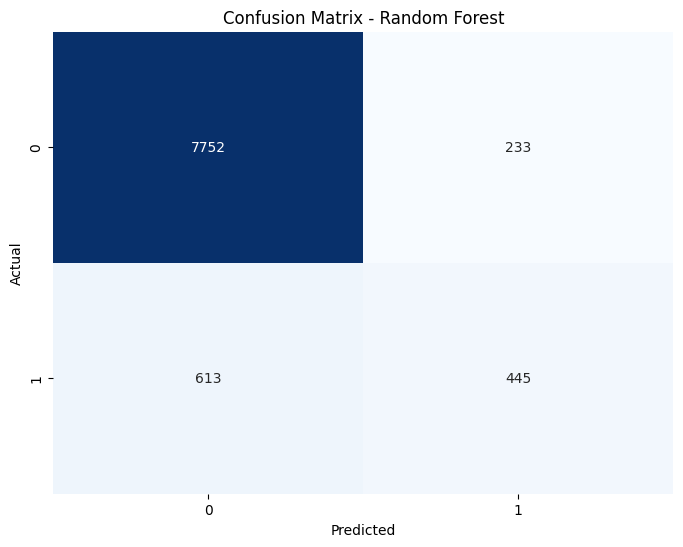

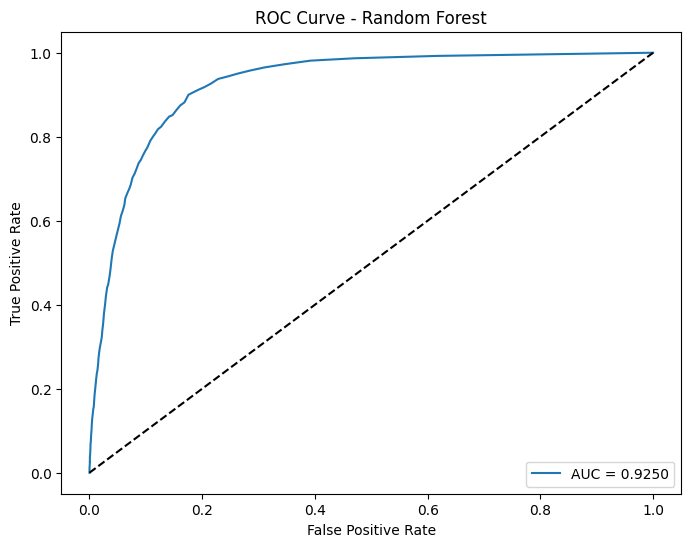


===== Neural Network =====

--- Neural Network Results ---
Accuracy: 0.8994
AUC-ROC: 0.9024

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7985
           1       0.61      0.39      0.48      1058

    accuracy                           0.90      9043
   macro avg       0.77      0.68      0.71      9043
weighted avg       0.89      0.90      0.89      9043



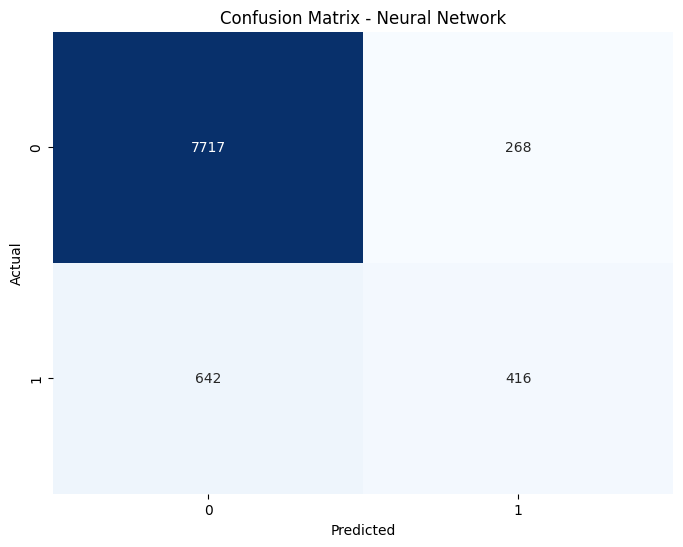

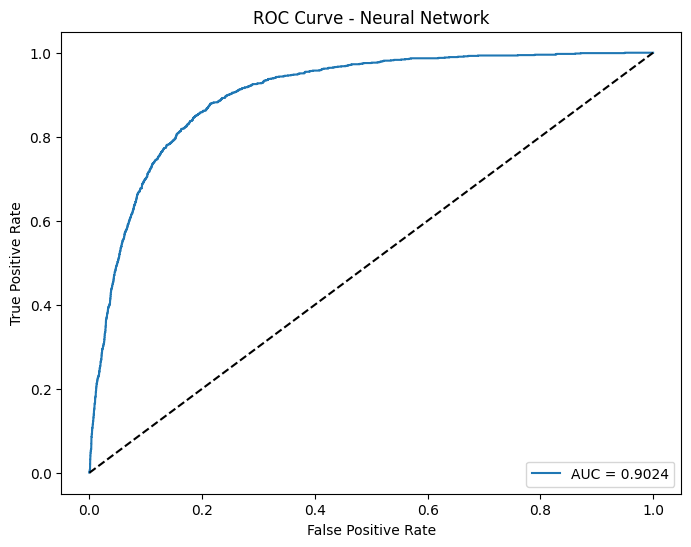


===== XGBoost =====

--- XGBoost Results ---
Accuracy: 0.9058
AUC-ROC: 0.9267

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      7985
           1       0.63      0.48      0.54      1058

    accuracy                           0.91      9043
   macro avg       0.78      0.72      0.74      9043
weighted avg       0.90      0.91      0.90      9043



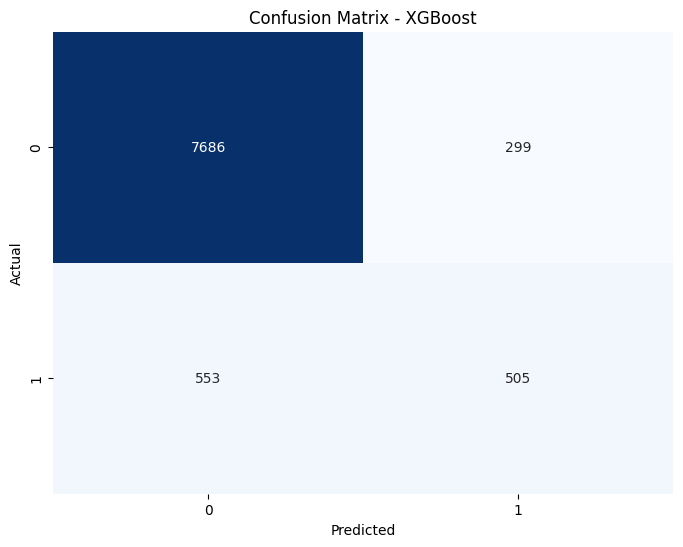

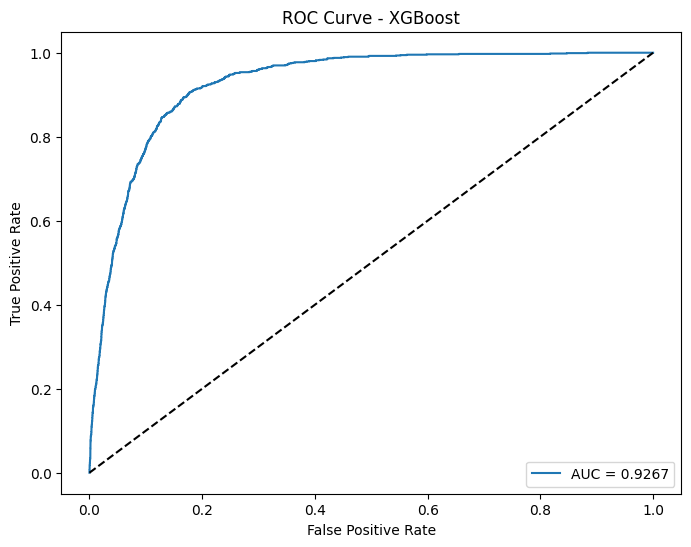


===== LightGBM =====
[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327

--- LightGBM Results ---
Accuracy: 0.9059
AUC-ROC: 0.9329

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      7985
           1       0.63      0.46      0.53      1058

    accuracy                           0.91      9043
   macro avg       0.78      0.71      0.74      9043
weighted avg       0.90      0.91      0.90      9043



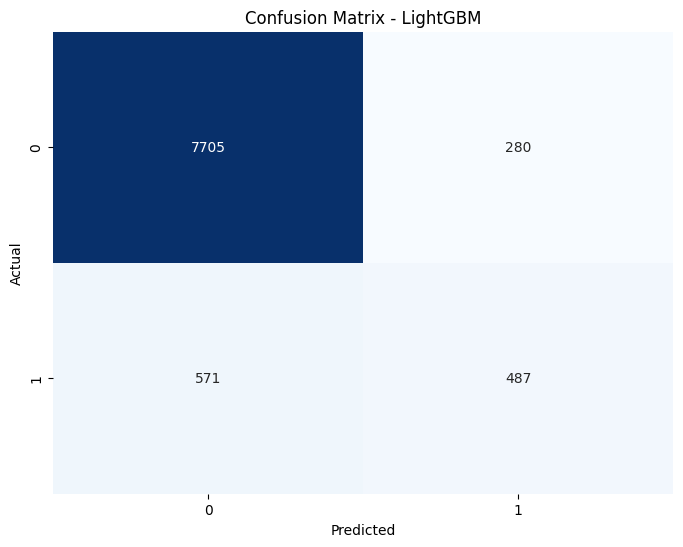

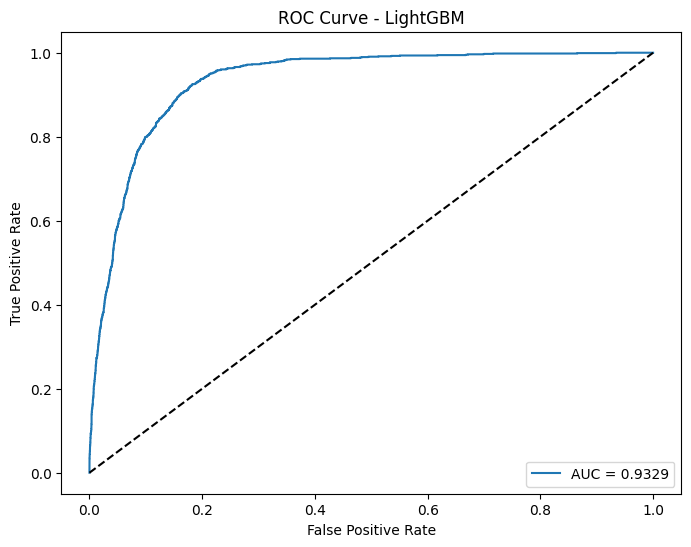


===== Gradient Boosting =====

--- Gradient Boosting Results ---
Accuracy: 0.9034
AUC-ROC: 0.9224

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7985
           1       0.65      0.39      0.48      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.68      0.72      9043
weighted avg       0.89      0.90      0.89      9043



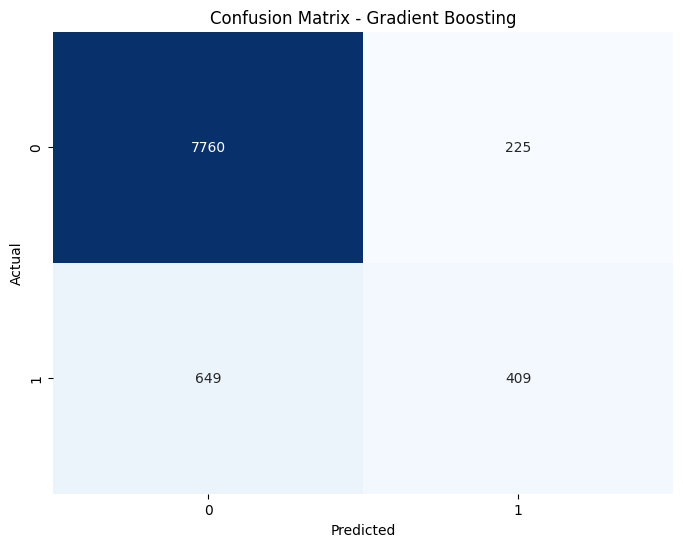

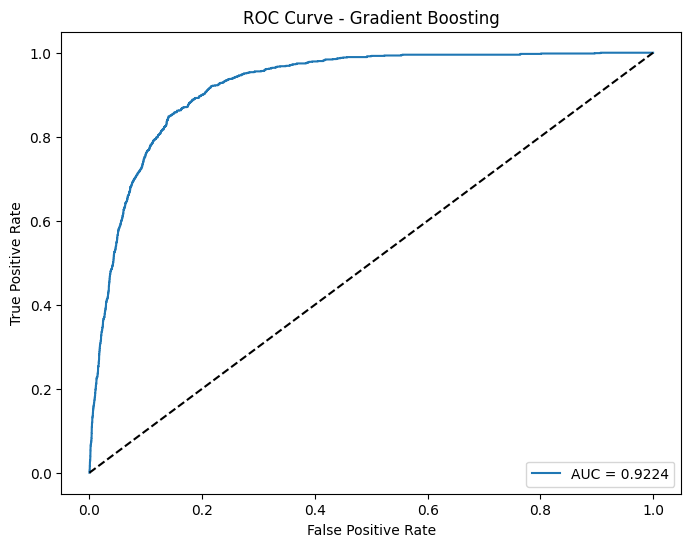


===== AdaBoost =====

--- AdaBoost Results ---
Accuracy: 0.8938
AUC-ROC: 0.8910

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7985
           1       0.59      0.31      0.41      1058

    accuracy                           0.89      9043
   macro avg       0.75      0.64      0.67      9043
weighted avg       0.88      0.89      0.88      9043



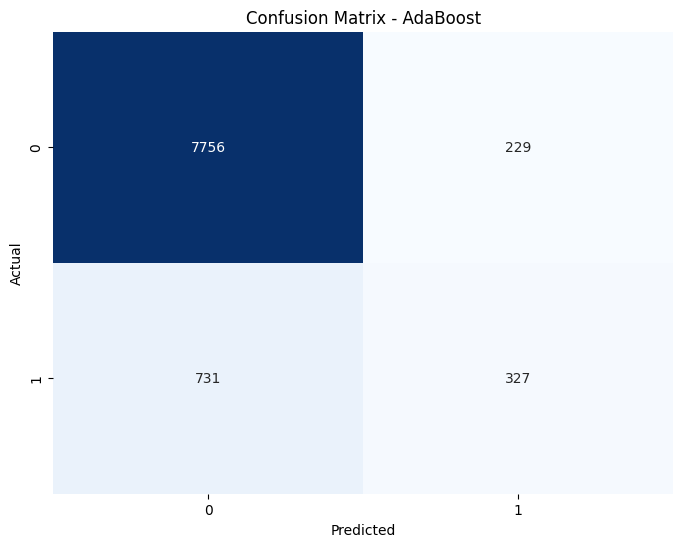

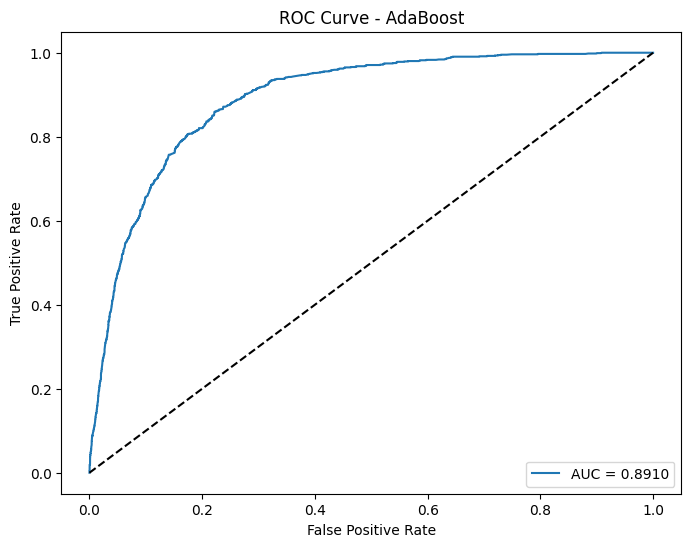


===== Support Vector Machine =====

--- Support Vector Machine Results ---
Accuracy: 0.8972
AUC-ROC: 0.8543

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7985
           1       0.65      0.26      0.37      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.62      0.66      9043
weighted avg       0.88      0.90      0.88      9043



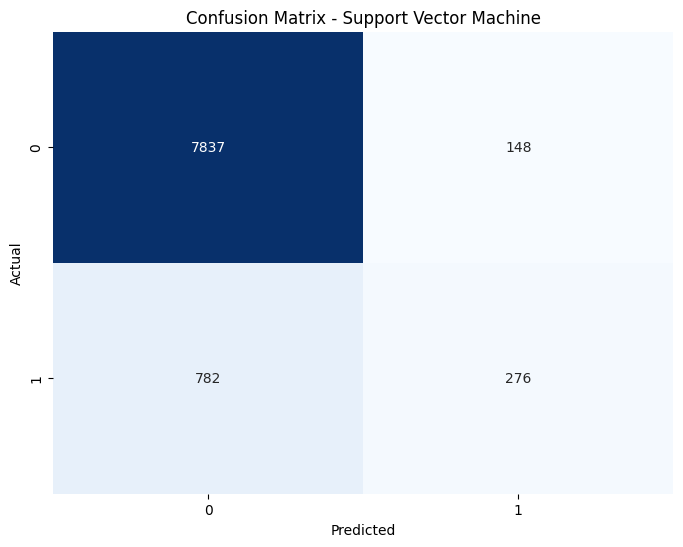

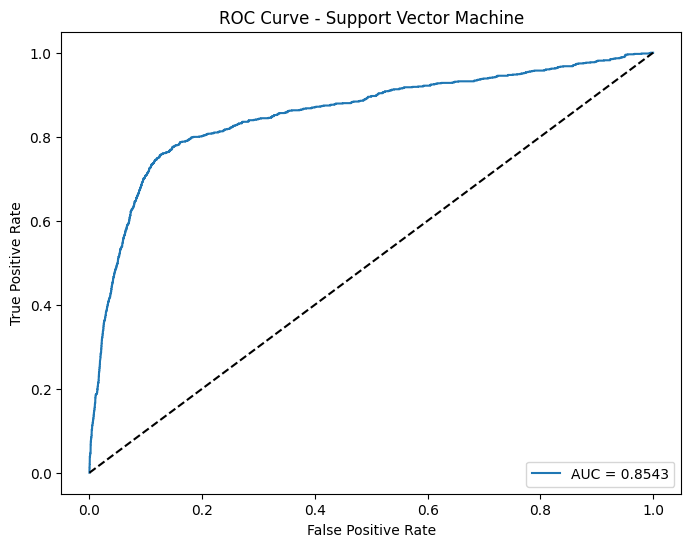


===== Logistic Regression =====

--- Logistic Regression Results ---
Accuracy: 0.8914
AUC-ROC: 0.8726

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7985
           1       0.59      0.23      0.33      1058

    accuracy                           0.89      9043
   macro avg       0.75      0.60      0.63      9043
weighted avg       0.87      0.89      0.87      9043



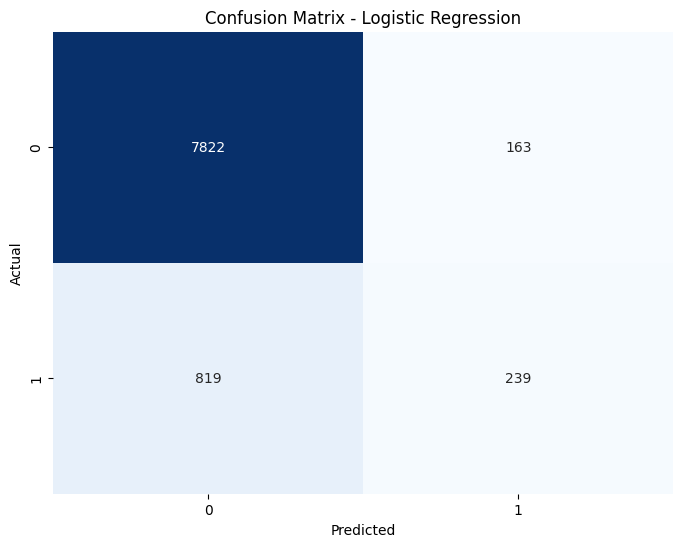

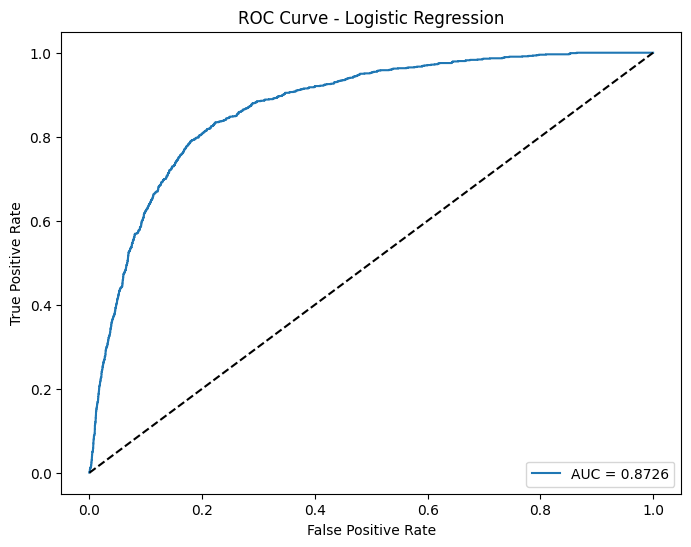


===== Model Comparison =====
                        Accuracy   AUC-ROC
LightGBM                0.905894  0.932890
XGBoost                 0.905783  0.926749
Random Forest           0.906447  0.925024
Gradient Boosting       0.903351  0.922377
Neural Network          0.899370  0.902435
AdaBoost                0.893841  0.891013
Logistic Regression     0.891408  0.872583
Support Vector Machine  0.897158  0.854326


<Figure size 1400x800 with 0 Axes>

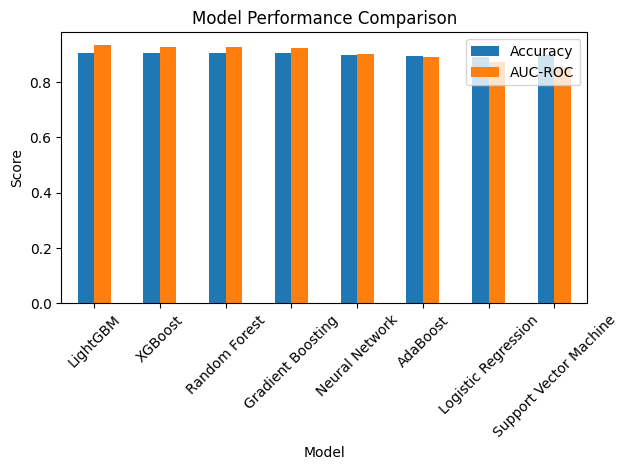

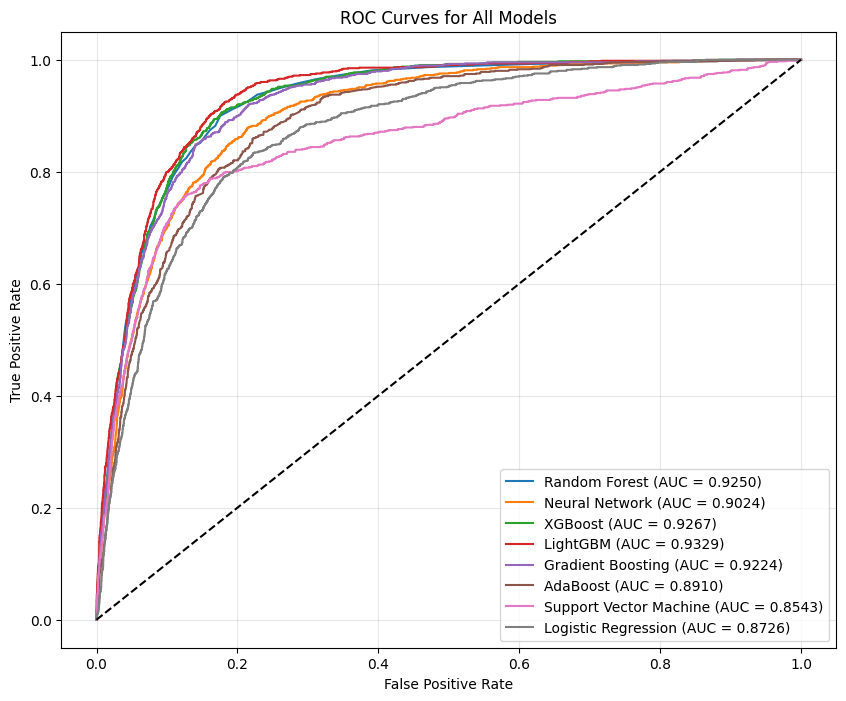

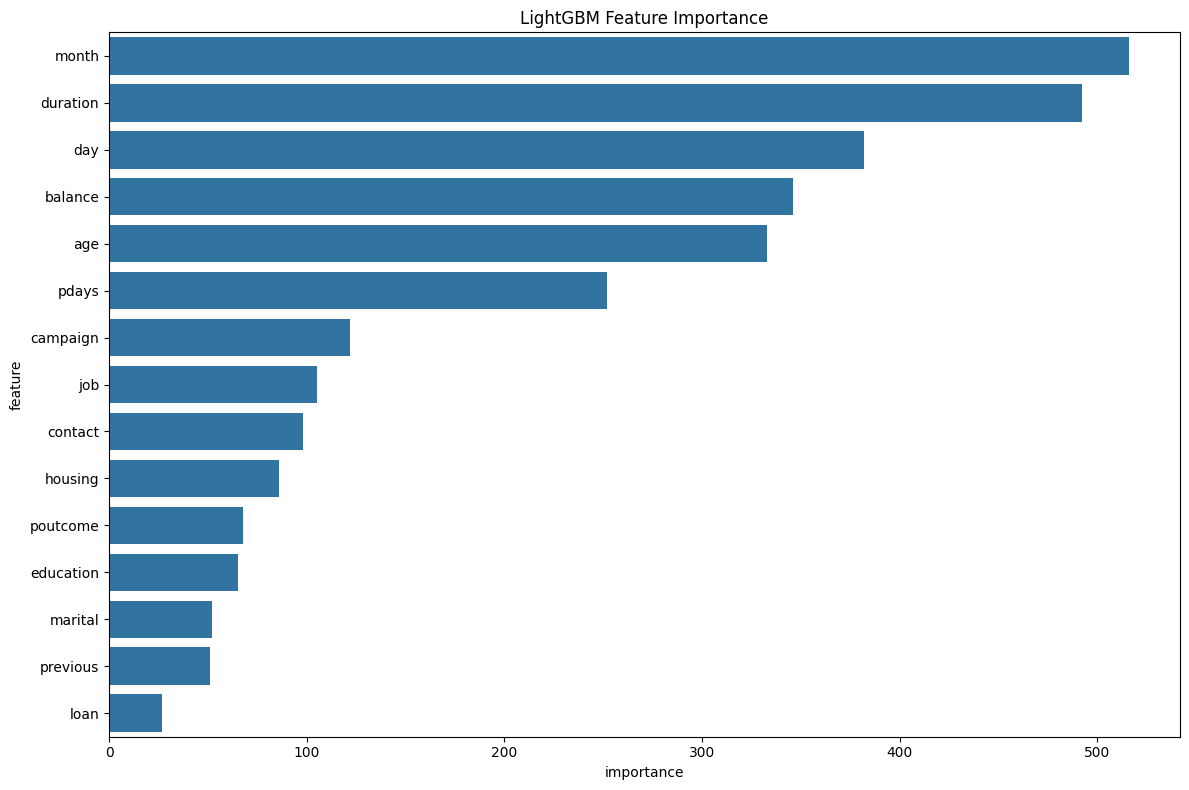


===== Cross-Validation for LightGBM =====
[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 987
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 989
[LightGBM] [Info] Number of data points in the train set: 36169, number 

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Function to load and preprocess data
def load_and_preprocess_data(file_path):
    """
    Load and preprocess the bank marketing dataset
    """
    # Load the dataset
    df = pd.read_csv(file_path, sep=';')
    
    # Convert categorical variables to numeric
    le = LabelEncoder()
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = le.fit_transform(df[col])
    
    # Define features and target
    X = df.drop('y', axis=1)
    y = df['y']
    
    return X, y

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train the model and evaluate its performance
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # For ROC curve and AUC
    try:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    except:
        # For models that don't support predict_proba
        if hasattr(model, 'decision_function'):
            y_pred_proba = model.decision_function(X_test)
        else:
            y_pred_proba = y_pred  # Fallback
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    try:
        auc_score = roc_auc_score(y_test, y_pred_proba)
    except:
        auc_score = np.nan
    
    # Print results
    print(f"\n--- {model_name} Results ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC-ROC: {auc_score:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Create confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    try:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc='lower right')
    except:
        plt.text(0.5, 0.5, "ROC curve could not be computed", 
                horizontalalignment='center', verticalalignment='center')
    plt.show()
    
    return model, accuracy, auc_score

# Main code execution
if __name__ == "__main__":
    # Load your dataset here
    # For example: X, y = load_and_preprocess_data('bank-full.csv')
    
    # For demonstration, let's use a sample dataset from sklearn
    # from sklearn.datasets import load_breast_cancer
    # dataset = load_breast_cancer()
    # X = pd.DataFrame(dataset.data, columns=dataset.feature_names)
    # y = pd.Series(dataset.target)
    
    X, y = load_and_preprocess_data('../data/bank.csv')
    # Print dataset information
    print("Dataset shape:", X.shape)
    print("Number of classes:", len(np.unique(y)))
    print("Class distribution:")
    print(y.value_counts())
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Dictionary to store results
    results = {}
    
    # Initialize models with parameters from the image
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'LightGBM': LGBMClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'AdaBoost': AdaBoostClassifier(random_state=42),
        'Support Vector Machine': SVC(probability=True, random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=500, random_state=42)
    }
    
    # Train and evaluate each model
    for name, model in models.items():
        print(f"\n===== {name} =====")
        model, accuracy, auc = evaluate_model(
            model, X_train_scaled, X_test_scaled, y_train, y_test, name
        )
        results[name] = {'model': model, 'accuracy': accuracy, 'auc': auc}
    
    # Compare all models
    print("\n===== Model Comparison =====")
    comparison = pd.DataFrame({
        'Accuracy': [results[model]['accuracy'] for model in results],
        'AUC-ROC': [results[model]['auc'] for model in results]
    }, index=results.keys())
    
    print(comparison.sort_values('AUC-ROC', ascending=False))
    
    # Plot model comparison
    plt.figure(figsize=(14, 8))
    comparison.sort_values('AUC-ROC', ascending=False).plot(kind='bar')
    plt.title('Model Performance Comparison')
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Plot ROC curves for all models in one figure
    plt.figure(figsize=(10, 8))
    for name in results:
        model = results[name]['model']
        try:
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            plt.plot(fpr, tpr, label=f"{name} (AUC = {results[name]['auc']:.4f})")
        except:
            continue
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Models')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()
    
    # Identify the best model based on AUC-ROC
    best_model_name = comparison.sort_values('AUC-ROC', ascending=False).index[0]
    best_model = results[best_model_name]['model']
    
    # Feature importance for the best model (if it has feature_importances_ attribute)
    if hasattr(best_model, 'feature_importances_'):
        plt.figure(figsize=(12, 8))
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
        plt.title(f'{best_model_name} Feature Importance')
        plt.tight_layout()
        plt.show()
    
    # Cross-validation for the best model
    print(f"\n===== Cross-Validation for {best_model_name} =====")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring='roc_auc')
    
    print(f"Cross-Validation AUC Scores: {cv_scores}")
    print(f"Mean AUC: {cv_scores.mean():.4f}")
    print(f"Standard Deviation: {cv_scores.std():.4f}")
    
    # Save the best model (uncomment to use)
    import joblib
    joblib.dump(best_model, 'best_model.pkl')
    print(f"Best model ({best_model_name}) saved as 'best_model.pkl'")
